In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import openai
import yaml

from utils import *

import autoKG_full as AKG

In [2]:
with open("config.yaml", 'r') as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


COMPLETIONS_MODEL = params["OPENAI_API_MODEL"]
EMBEDDING_MODEL = params["EMBEDDING_MODEL"]
my_api_key = params["OPENAI_API_KEY"]
openai.api_key = my_api_key

os.environ['OPENAI_API_KEY'] = my_api_key
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [4]:
directory = "raw_data"
texts, sources = load_and_process_files(directory,
                                        chunk_size=200,
                                        separator=None)



In [5]:
main_topic = "Konwledge graph, Language Model"

KG_class = AKG.autoKG(texts=texts,
                         source=sources,
                         embedding_model=EMBEDDING_MODEL,
                         llm_model=COMPLETIONS_MODEL,
                         openai_api_key=OPENAI_API_KEY,
                         main_topic=main_topic,
                         embedding=True)

In [6]:
# step one: remove duplicates
to_keep, to_delete, remains = KG_class.remove_same_text(use_nn=True, n_neighbors=25, thresh=1e-6, update=True)
print(len(to_keep))

1123


In [7]:
# step two: extract keywords with two methods
core_list_1, all_tokens = KG_class.cluster(15,
                               clustering_method='NgJordanWeiss',
                               max_texts=15,
                               select_mtd='similarity',
                               prompt_language='English',
                               num_topics=10,
                               max_length=3,
                               post_process=True,
                               add_keywords=False,
                               verbose=False)
print("Number of keywords selected:", len(core_list_1))
print("Token used:", all_tokens)

core_list_2, all_tokens = KG_class.cluster(15,
                               clustering_method='k_means',
                               max_texts=15,
                               select_mtd='similarity',
                               prompt_language='English',
                               num_topics=10,
                               max_length=3,
                               post_process=True,
                               add_keywords=True)
print("Number of keywords selected:", len(core_list_2))
print("Token used:", all_tokens)

print("Number of keywords:", len(KG_class.keywords))

Before Post Process: 159
After Post Process: 159
Number of keywords selected: 159
Token used: 57680
Before Post Process: 217
After Post Process: 217
Number of keywords selected: 217
Token used: 61636
Number of keywords: 330


In [8]:
_ = KG_class.sub_entry_filter()
print("Number of keywords:", len(KG_class.keywords))

Number of keywords: 291


In [9]:
_, all_tokens = KG_class.final_keywords_filter()
print("Token used:", all_tokens)
print("Number of keywords:", len(KG_class.keywords))


Token used: 8147
Number of keywords: 301


In [10]:
KG_class.make_graph(30)
pred_mat, U_mat, A = KG_class.coretexts_seg_individual(k=30, trust_num=5, negative_multiplier=7, seg_mtd='laplace',
                                                return_mat=True, connect_threshold=0.2)

In [11]:
KG_class.get_dist_mat()
print(KG_class.check_completion())

True


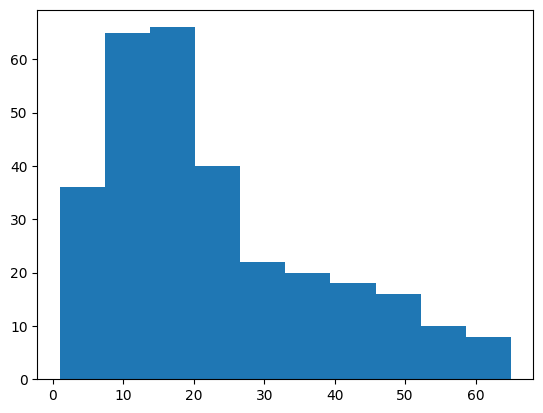

In [12]:
deg_mat = np.sum(np.array(A.todense()) > 0, axis=0)
plt.hist(deg_mat)
plt.show()

In [13]:
KG_class.save_data(os.path.join('KG_data', 'ref_paper_KG.npy'), include_texts=True)


Successfully save to KG_data\ref_paper_KG.npy
